In [86]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fsolve
import matplotlib.pyplot as plt
import time
from distillation import antoineEthanolWater, wilsonActFact
from integrate_ketn01 import solve_ivp_mass

#FRÅGOR: Massmatrisen, Columngrafen

In [87]:
def ActFactEquil(x,Tguess,P):
    T = fsolve(lambda T: ActFactRes(x,T,P), Tguess)
    [y,y2] = ActFact(x,T,P)
    return y,T

def ActFactRes(x,T,P):
    [y1,y2] = ActFact(x,T,P)
    res = 1-y1-y2
    return res

def ActFact(x,T,P):
    [p01,p02] = antoineEthanolWater(T)
    [gamma1,gamma2] = wilsonActFact(x,T)
    y1 = gamma1*p01*x/P
    y2 = gamma2*p02*(1-x)/P
    return y1,y2

def equilRelVol(x,alpha):
    y = alpha*x/(1+(alpha-1)*x)
    return y


def colmodel(t,z,dd):
    N = dd['N']
    x = z[:N]
    xb = z[N]
    x0 = z[N+1]
    T = z[N+2:2*N+2]
    Tb = z[2*N+2]
    # Equil calc
    [y, y2] = ActFact(x, T, dd['P'])
    [yb, yb2] = ActFact(np.array([xb]), np.array([Tb]), dd['P'])
    # Static total condensor
    dd['L'] = dd['RD']/(1+dd['RD'])*dd['V']
    
    # Liquid composition from tray above
    xim1 = np.hstack((x0, x[:N-1]))
    # Vapour composition from tray below
    yip1 = np.hstack((y[1:],yb))
    # Liquid flows
    LF = dd['L'] + np.hstack((np.zeros(dd['Nf']), dd['F']*np.ones(N-dd['Nf']) ) ) 
    #LF = 640+[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2268*1,2268*1]

    FF = np.hstack( ( np.zeros(dd['Nf']-1),1,np.zeros(N-dd['Nf'])) ) *dd['F']
  
    # composition balances
    dxdt = 1/dd['M']*(LF*(xim1-x) + dd['V']*(yip1-y) + FF*(dd['xfeed']-x))
    dxbdt = 1/dd['Mb']*(LF[-1]*(x[-1]-xb) + dd['V']*(xb-yb))
    dx0dt = 1/dd['Mc']*(dd['V']*(y[0]-x0))
    req = 1 - y - y2
    reqb = 1 - yb - yb2
    # derivatives and residuals
    dzdt = np.hstack((dxdt, dxbdt, dx0dt, req, reqb))
    return dzdt

ss_sol: [8.12674386e-01 7.99640973e-01 7.87475451e-01 7.75790676e-01
 7.64257779e-01 7.52567278e-01 7.40395379e-01 7.27367489e-01
 7.13009978e-01 6.96676490e-01 6.77423352e-01 6.53781731e-01
 6.23310358e-01 5.81658539e-01 5.20541662e-01 4.24208053e-01
 2.76915302e-01 1.35879385e-01 6.74858196e-02 1.94014526e-02
 3.90053424e-03 8.27075634e-01 3.51181377e+02 3.51206742e+02
 3.51234328e+02 3.51264229e+02 3.51296885e+02 3.51333056e+02
 3.51373875e+02 3.51421003e+02 3.51476898e+02 3.51545327e+02
 3.51632313e+02 3.51748046e+02 3.51910978e+02 3.52157486e+02
 3.52567219e+02 3.53336051e+02 3.54961219e+02 3.58079583e+02
 3.61819954e+02 3.68049136e+02 3.71899779e+02]


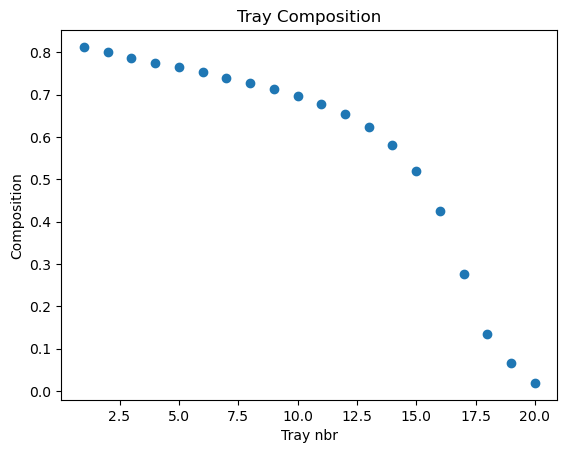

In [88]:

# destcol_actfact is a tray based model
# with activity factor model and equi-molar flows
# PARAMETERS
dd = {}
# *** equilibrium data
dd['P'] = 101300
# *** Flows:
# Feed
dd['F'] = 2268#*0.9 # kmole/h
dd['xfeed'] = 0.144#*1.1 # mole fraction
dd['alpha'] = 2.5
# Reflux ratio
dd['RD'] = 1.66
dd['BD'] = 1882 # help to set the nominal flow
dd['DD'] = dd['F']-dd['BD'] # help to set the nominal flow
dd['V'] = (1+dd['RD'])*dd['DD']
# *** Column
# Tray numbering
N = 20
dd['N'] = N
dd['Nf'] = 18
dd['Nr'] = dd['Nf']-1 # rectifier
dd['Ns'] = N-dd['Nf'] # stripper
# Tray hold-up
dd['M'] = 20 # kmole
dd['Mc'] = 200
dd['Mb'] = 500
xinit = dd['xfeed']*np.ones(N+2)
T0 = 273+80
Tinit = T0*np.ones(N+1)
init = np.hstack((xinit, Tinit))
Tspan = [0, 50]
n_ode = N+2 #22
n_ae = N+1 #21
M11 = np.eye(n_ode) #(22,22)
M12 = np.zeros((n_ode,n_ae)) #(22,21)

#VSTACK(M11,M12) = (22,43)
M2_ = np.zeros((n_ae,n_ae+n_ode)) #(21,43)
MM = np.vstack(( np.hstack((M11,M12)),M2_ ))

#STEADY STATE
ss_sol=fsolve(lambda x: colmodel(0,x,dd),init)
fig, ax = plt.subplots()
ax.plot(np.arange(1,21,1),ss_sol[:20], 'o')
ax.set_title('Tray Composition')
ax.set_ylabel('Composition')
ax.set_xlabel('Tray nbr')
print(f"ss_sol: {ss_sol}")

Final Run Statistics: --- 

 Number of steps                                 : 453
 Number of function evaluations                  : 797
 Number of Jacobian evaluations                  : 28
 Number of function eval. due to Jacobian eval.  : 797
 Number of error test failures                   : 3
 Number of nonlinear iterations                  : 797
 Number of nonlinear convergence failures        : 2

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 50.0 seconds.
Elapsed simulation time: 0.3765434001106769 seconds.
INIT VALUES: [8.12674386e-01 7.99640973e-01 7.87475451e-01 7.75790676e-01
 7.64257779e-01 7.52567278e-01 7.40395379e-01 7.27367488e-01
 7.13009978e-01 6.96676490e-01 6.77423352e-01 6.53781730e-01
 6.23310357e-01 5.81658539e-01 5.20541661e-01 4.24208052e-01
 2.76915301e-01 1.35879385e-

Text(0.5, 1.0, 'Tray concentrations')

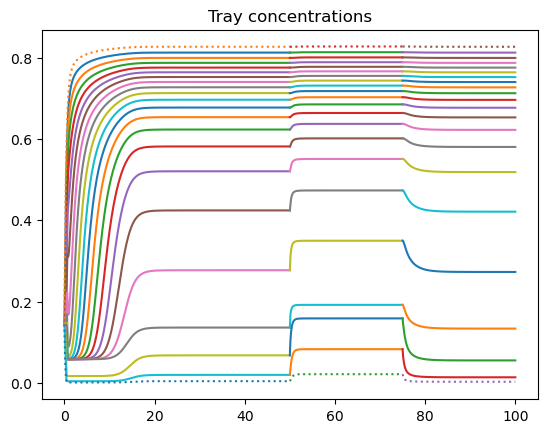

In [89]:
fig, ax = plt.subplots()
# Use solve_ivp_mass instead of solve_ivp in order to solve a dae
dyn = solve_ivp_mass(lambda t,x: colmodel(t,x,dd), Tspan, init, n=2000, mass=MM)
dd['dyn'] = dyn
ss_sol = fsolve(lambda x: colmodel(0,x,dd), init)
dd['ss'] = ss_sol
# plot of tray concentrations
#plt.plot(dyn.t, dyn.y[:N,:].T)
#plt.plot(dyn.t, dyn.y[N:N+2,:].T,':')
#plt.title('tray concentrations')

Tspan2=[50, 75]
dd['xfeed']=1.1*dd['xfeed']

print(f"INIT VALUES: {dyn.y[:,-1]}")
dyn2 = solve_ivp_mass(lambda t,x: colmodel(t,x,dd), Tspan2, dyn.y[:,-1], \
mass=MM)
dd['dyn2']=dyn2
Tspan3=[75, 100]
dd['F']=0.9*dd['F']
dyn3 = solve_ivp_mass(lambda t,x: colmodel(t,x,dd), Tspan3, dyn2.y[:,-1], \
mass=MM)
dd['dyn3']=dyn3
# Plot of tray concentrations

ax.plot(dyn.t,dyn.y[:N,:].T)
ax.plot(dyn.t,dyn.y[N:N+2,:].T,':')
ax.plot(dyn2.t,dyn2.y[:N,:].T)
ax.plot(dyn2.t,dyn2.y[N:N+2,:].T,':')
ax.plot(dyn3.t,dyn3.y[:N,:].T)
ax.plot(dyn3.t,dyn3.y[N:N+2,:].T,':')
ax.set_title('Tray concentrations')

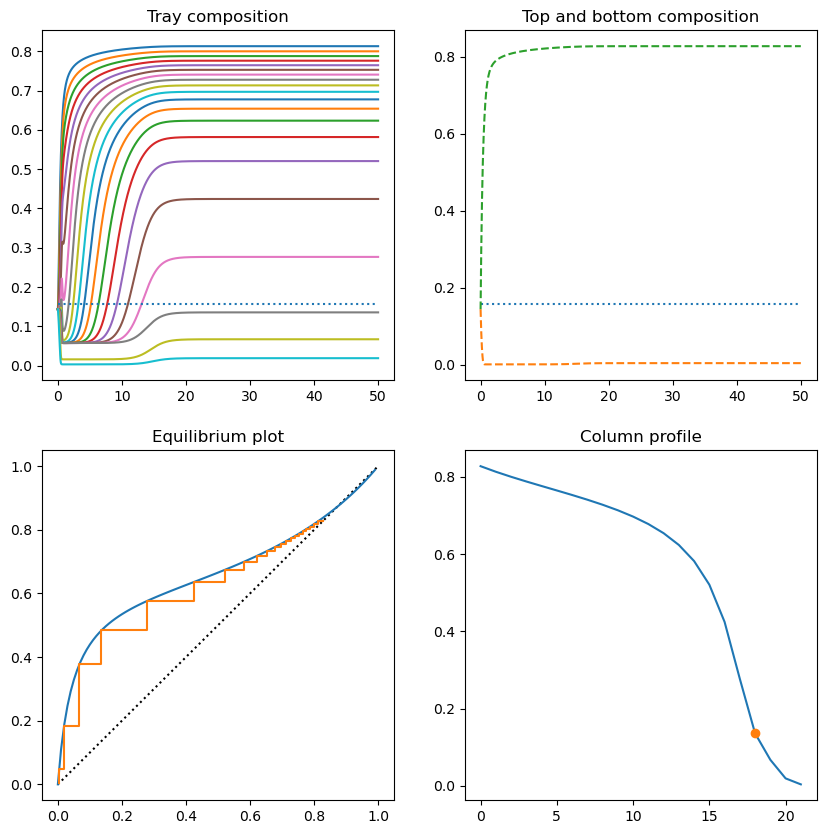

In [90]:
ss = dd['ss']
ss = ss_sol
dyn = dd['dyn']
N = dd['N']
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()
ax[0].plot(dyn.t,dyn.y[:N,:].T)
ax[0].plot([0,dyn.t[-1]], dd['xfeed']*np.ones(2), ':')
ax[0].set_title('Tray composition')

ax[1].plot([0, dyn.t[-1]], dd['xfeed']*np.ones(2), ':')
ax[1].plot(dyn.t, dyn.y[N:N+2,:].T,'--')
ax[1].set_title('Top and bottom composition')

xj = np.arange(0, 1, 0.01) # start,stop, step
Tguess = (273+80)*np.ones(len(xj))
yj, Tj = ActFactEquil(xj, Tguess, dd['P'])
xx = np.zeros(2*(N+1)+1)
xx[::2] = np.hstack( (ss[N+1], ss[:N], ss[N]) )
xx[1::2] = np.hstack( (ss[:N], ss[N] ) )
Tguess = (273+80)*np.ones(N+1)
ysol, Tsol = ActFactEquil(ss[:N+1], Tguess, dd['P'])
yy = np.zeros(2*(N+1)+1)
yy[::2] = np.hstack( (ysol[:N], ysol[N], ss[N]) )
yy[1::2] = np.hstack( (ysol[:N], ysol[N]) )
ax[2].plot([0, 1],[0, 1],':k')
ax[2].plot(xj, yj, xx, yy)
ax[2].set_title('Equilibrium plot')

ax[3].plot(np.arange(0,N+2), np.hstack((ss[N+1], ss[:N], ss[N])) )
ax[3].plot(dd['Nf'], ss[dd['Nf']-1], 'o')
ax[3].set_title('Column profile')
def ActFact(x,T,P):
    [p01,p02] = antoineEthanolWater(T)
    [gamma1,gamma2] = wilsonActFact(x,T)
    y1 = gamma1*p01*x/P
    y2 = gamma2*p02*(1-x)/P
    return y1,y2

def ActFactEquil(x,Tguess,P):
    sol = root(lambda T: ActFactRes(x,T,P), Tguess, method='hybr')
    T = sol['x']
    [y,y2] = ActFact(x,T,P)
    return y,T
def ActFactRes(x,T,P):
    [y1,y2] = ActFact(x,T,P)
    res = 1-y1-y2
    return res

